# 【点滴】学习傅里叶变换

### 1 应用

傅里叶变换常常被用在将时域上的时间信号转换至频域，常见的时变信号包括音波，电信号以及机械振动等。在建筑工程中，傅里叶变换一般被应用于确定震荡信号的主要频率，如果这个频率和建筑自身的频率相接近时，系统的振动会因为引发的共振而增大，当共振增强到一定程度，建筑便可能倒塌。

### 2 理论认识

傅里叶变换的一个基本思想是，**任意一个函数都可以表示为一系列（甚至无穷多）的正弦函数或余弦的叠加**。如下图所示，一系列正弦函数（蓝色波浪线）叠加可以得到一个阶跃函数（红色）：

<center>
    <img style="border-radius: 0.3125em;
    box-shadow: 0 2px 4px 0 rgba(34,36,38,.12),0 2px 10px 0 rgba(34,36,38,.08);" 
    src="https://www.ritchievink.com/img/post-5-fft/fig_2.png">
    <br>
    <div style="color:orange; border-bottom: 1px solid #d9d9d9;
    display: inline-block;
    color: #999;
    padding: 2px;">傅里叶变换示例</div>
</center>

傅里叶变换将时域上的信号分解，转换至频域信号，最终得到组成该信号的各个正弦信号的频率信息。其中，离散傅里叶变换（Discrete Fourier Transfor）数学表达如下：

$X_k = \sum_{n=0}^{N-1}x_n  e^{-2 \pi ikn/N},(k=0,1...N-1)$

其中，

由欧拉公式我们知道，$e^{it}=cos t + i* sin t$, 因此$e^{-2 \pi ikn/N}=cos 2\pi \frac{kn}{N} -i * sin 2\pi \frac{kn}{N}$；

$X_k$表示傅里叶变换结果,包括信号的幅度和相位,而对于长度为N的时间序列，把原信号采样间隔的倒数视为原信号的基础周期（fundamental period）$T_0$，$\frac{k}{NT_0}$表示第k个信号频率；

$x_n$表示原时域信号中第n个采样信号值。

python实现上述表达如下：

In [1]:
import numpy as np

def DFT(x):
    """
    Compute the discrete Fourier Transform of the 1D array x
    :param x: (array)
    """

    N = x.size
    n = np.arange(N)
    k = n.reshape((N, 1))
    e = np.exp(-2j * np.pi * k * n / N)
    return np.dot(e, x)

In [9]:
from datetime import datetime 
a=datetime.now()  
x=np.array([i for i in range(10000)])
X=DFT(x)
b=datetime.now() 
print('time cost for DFT: %g s'%((b-a).seconds))

time cost for DFT: 9 s


由离散傅里叶变换的表达可知，其时间复杂度为$O(N^2)，$在上述示例中，傅里叶变换包含10000个采样的时域信号花费9s,可以说效率较低。此时，快速傅里叶变换（Fast Fourier Transform）应运而生，它的时间复杂度为$O(NlogN)$。下面分析一下快速傅里叶变换，首先通过两个正弦信号构造一个时域信号：

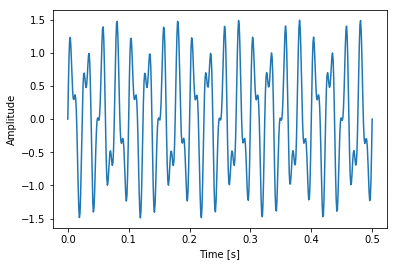

In [163]:
%matplotlib inline
import matplotlib.pyplot as plt
t = np.linspace(0, 0.5, 500)
s = np.sin(40 * 2 * np.pi * t) + 0.5 * np.sin(90 * 2 * np.pi * t)

plt.ylabel("Amplitude")
plt.xlabel("Time [s]")
plt.plot(t, s)
plt.show()

通过numpy自带的快速傅里叶变换工具包，我们可以得到该信号的快速傅里叶变换结果：

In [164]:
fft = np.fft.fft(s)


for i in range(2):
    print("Value at index {}:\t{}".format(i, fft[i + 1]), "\nValue at index {}:\t{}".format(fft.size -1 - i, fft[-1 - i]))


Value at index 0:	(0.00038048349283981153-0.06055503176189958j) 
Value at index 499:	(0.00038048349283897887+0.06055503176189887j)
Value at index 1:	(0.0015317714831372398-0.12188808528069522j) 
Value at index 498:	(0.001531771483137656+0.12188808528069539j)


我们输出了快速傅里叶变换第一个和最后一个结果，以及第二个和倒数第二个结果，可以看到，这两对结果是共轭复数，即实部一致，虚部的幅度也相同，但符号相反。实际上，**对于长度为N的时间序列，其第n个傅里叶变换信号与第N-n个傅里叶变换共轭**（可分别将n,N-n代入定义式证明），所以我们只需要取前半部分的傅里叶变换结果，就足够分析源信号的频谱情况。

快速傅里叶变换的结果包含的信息有某频率正弦信号的幅度，以及其相位。

dominat frequency: 40


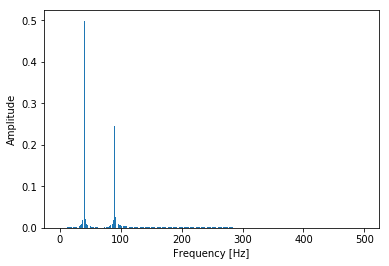

In [166]:
fft = np.fft.fft(s)
T = t[1] - t[0]  # sampling interval 
N = s.size

# 1/T = frequency
f = np.linspace(0, 1 / T, N)
T_=1/f[list(np.abs(fft)[:N // 2] * 1 / N).index(max(np.abs(fft)[:N // 2] * 1 / N))]

## when N is larger to an extent, the dominat frequency is detected correctly and will keep the same even if the N become larger
print('dominat frequency: %g'%(1/T_))

plt.ylabel("Amplitude")
plt.xlabel("Frequency [Hz]")
plt.bar(f[:N // 2], np.abs(fft)[:N // 2] * 1 / N, width=1.5)  # 1 / N is a normalization factor
plt.show()

### 下面通过一个例子来介绍如何确定一个信号的周期。

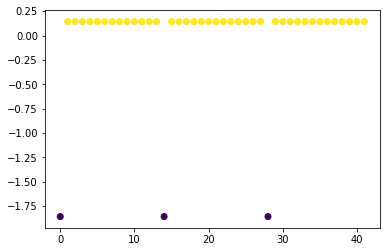

In [263]:
N=2000 # 采样个数
t_min=0
t_max=2.
t = np.linspace(t_min, t_max, N) #采样集合

#时域序列
s = np.ones(N) 
period=14 # 设置周期 周期越大，采样个数应越大
s[::period] = -1

s=s-sum(s)/N # substract mean of the data to eliminate DC component

plt.scatter([i for i in range(s[:3*period].shape[0])],s[:3*period],c=s[:3*period])
plt.show()

上述采样信号示例中，我们可以得到:

**采样信号最小周期**$T_0=\frac{t_{max}-t_{min}}{N}$;

信号的**采样率**$f_{sample}=\frac{1}{T_0}$(*为了保证傅里叶变换后信号可恢复，采样频率应大于等于两倍信号实际频率*);

**frequency resolution**=$\frac{f_{sample}}{N}=\frac{1}{t_{max}-t_{min}}$;

**temporal resolution**=$\frac{1}{frequency\quad resolution}$

>Noted: At a fixed sampling rate, increasing frequency resolution decreases temporal resolution. 

In [264]:
T_0 =  (t_max-t_min)/N
f_s = 1/T_0
fr = f_s/N
tr = 1/fr
print(('sample rate: %g')%(f_s))
print(('fundamental period: %g')%(T_0))
print(('frequency resolution: %g')%(fr))
print(('temporal resolution: %g')%(tr))

sample rate: 1000
fundamental period: 0.001
frequency resolution: 0.5
temporal resolution: 2


傅里叶变换后得到频谱图，其x轴代表频率取值，取值区间为$[0,\frac{1}{T_0}]$，取值间隔为$\frac{1}{NT_0}$,因为存在复数共轭，我们画出前半部区间即可：

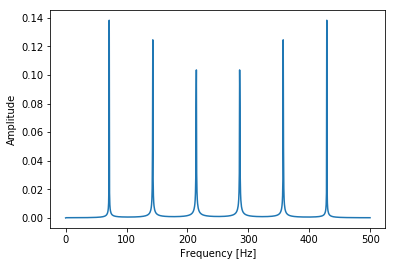

In [265]:
fft = np.fft.fft(s)
f = np.linspace(0, 1 / T_0, N) # 
plt.ylabel("Amplitude")
plt.xlabel("Frequency [Hz]")
plt.plot(f[:N // 2], np.abs(fft)[:N // 2] * 1 / N )  # 1 / N is a normalization factor
plt.show()

基于频谱图,我们可以发现信号占比较大的信号，求出其周期：

In [266]:

T_=1/f[list(np.abs(fft)[:N // 2] * 1 / N).index(max(np.abs(fft)[:N // 2] * 1 / N))]
print('raw period: %g'%T_)

raw period: 0.013979


领域化应用，基于采样频率得出的最小周期进行标准化，则可得“**相对周期**”=$\frac{raw \quad period}{fundamental \quad period}$

In [267]:
T_norm = T_/T_0
print('detect period: %g |real period: %g'%(T_norm,period))

detect period: 13.979 |real period: 14


### 参考资料

[1][Understanding the Fourier Transform](https://www.ritchievink.com/blog/2017/04/23/understanding-the-fourier-transform-by-example/)

[2][Unexpected peaks of FFT of positive-only sparse signal [OCTAVE or MATLAB]](https://stackoverflow.com/questions/42620759/unexpected-peaks-of-fft-of-positive-only-sparse-signal-octave-or-matlab)

[3][How do I obtain the frequencies of each value in an FFT?
](https://stackoverflow.com/questions/4364823/how-do-i-obtain-the-frequencies-of-each-value-in-an-fft)